In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_probability as tfp

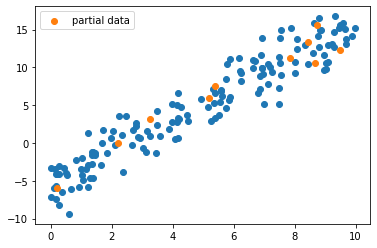

In [11]:
# Genereate a completely random dataset
def load_dataset(): 
    rng = np.random.RandomState(1)
    x = 10 * rng.rand(150)
    y = 2 * x - 5 + 2*rng.randn(150)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    x_partial= 10 * rng.rand(10)
    y_partial=2 * x_partial - 5 + 2*rng.randn(10)
    return  x.reshape(-1, 1), y.reshape(-1, 1), x_partial.reshape(-1, 1), y_partial.reshape(-1,1)
                                                                                            
                                                                                    
x,y,x_partial,y_partial=load_dataset()
plt.scatter(x,y)
plt.scatter(x_partial,y_partial, label="partial data")
plt.legend()

In [12]:
tfd = tfp.distributions
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
                                           
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))), ])
model_partial=model
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model_partial.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
model_partial.fit(x_partial,y_partial,epochs=1000,verbose= False)

In [13]:
rng = np.random.RandomState(0)
x_tst=10 * rng.rand(150)
y_hat=model(x_tst)
y_partial_hat=model_partial(x_tst)

/var/folders/m3/bnqwdhk17m7260tm_wkfnys40000gn/T/ipykernel_7229/1273881993.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, y, 'b.', label='observed',color="black");


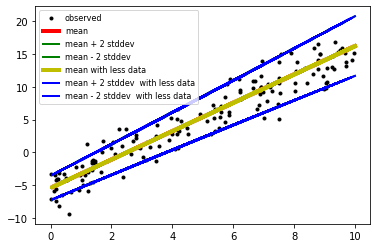

In [15]:
plt.plot(x, y, 'b.', label='observed',color="black");

m = y_hat.mean()
s = y_hat.stddev()

m_p=y_partial_hat.mean()
s_p=y_partial_hat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.plot(x_tst, m_p, 'y', linewidth=4, label='mean with less data');
plt.plot(x_tst, m_p + 2 * s_p, 'b', linewidth=2, label=r'mean + 2 stddev  with less data');
plt.plot(x_tst, m_p - 2 * s_p, 'b', linewidth=2, label=r'mean - 2 stddev  with less data');

plt.legend(prop={'size': 8})

In [16]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [17]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [18]:
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

model_partial=model
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model_partial.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);
model.fit(x, y, epochs=1000, verbose=False)
model_partial.fit(x_partial,y_partial,epochs=1000,verbose= False)

/var/folders/m3/bnqwdhk17m7260tm_wkfnys40000gn/T/ipykernel_7229/1824993301.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, y, 'b.', label='observed',color="black");


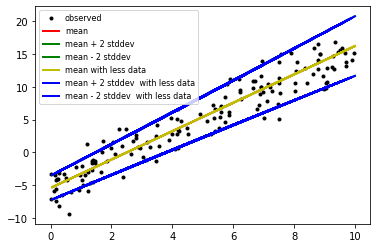

In [19]:
plt.plot(x, y, 'b.', label='observed',color="black");

m = y_hat.mean()
s = y_hat.stddev()

m_p=y_partial_hat.mean()
s_p=y_partial_hat.stddev()

plt.plot(x_tst, m, 'r', linewidth=2, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.plot(x_tst, m_p, 'y', linewidth=2
         , label='mean with less data');
plt.plot(x_tst, m_p + 2 * s_p, 'b', linewidth=2, label=r'mean + 2 stddev  with less data');
plt.plot(x_tst, m_p - 2 * s_p, 'b', linewidth=2, label=r'mean - 2 stddev  with less data');
plt.legend(prop={'size': 8})

In [20]:
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)

/var/folders/m3/bnqwdhk17m7260tm_wkfnys40000gn/T/ipykernel_7229/2210538730.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, y, 'b.', label='observed',color="black");


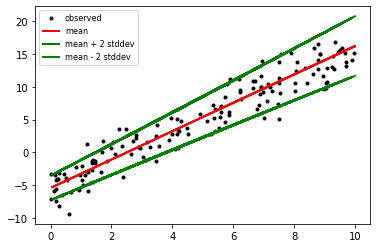

In [22]:
plt.plot(x, y, 'b.', label='observed',color="black");
m = y_hat.mean()
s = y_hat.stddev()


plt.plot(x_tst, m, 'r', linewidth=2, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');
plt.legend(prop={'size': 8})